In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

from pathlib import Path, PurePath

%matplotlib inline

## Helper function and constants

In [2]:
LEADS = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
DIAGS = [
    "1st degree AV block (1dAVb)",
    "right bundle branch block (RBBB)",
    "left bundle branch block (LBBB)",
    "sinus bradycardia (SB)",
    "atrial fibrillation (AF)",
    "sinus tachycardia (ST)",
]

## Extract data

In [3]:
import xml.etree.ElementTree as ET


def get_features(filename: str) -> str:
    feature_name = {
        'vent_rate': 'VentricularRate',
        'atri_rate': 'AtrialRate',
        # 'pr_intv': 'PRInterval',
        'qrs_dur': 'QRSDuration',
        'qt_intv':  'QTInterval',
        'qt_corr': 'QTCorrected',
        # 'p_axis':  'PAxis',
        # 'r_axis': 'RAxis',
        # 't_axis': 'TAxis',
        # 'qrs_count': 'QRSCount',
        # 'q_onset': 'QOnset',
        # 'q_offset': 'QOffset',
        # 'p_onset': 'POnset',
        # 'p_offset': 'POffset',
        # 't_offset': 'TOffset',
        # 'ecg_base': 'ECGSampleBase',
        # 'ecg_exp': 'ECGSampleExponent',
        # 'qtc_fred': 'QTcFrederica'
    }
        
    root = ET.parse(filename).getroot()
    
    diagnosis = ' '.join(stm.text.strip() for stm in root.findall('.//DiagnosisStatement/StmtText'))
    
    age = int(root.find('.//PatientAge').text)
    gender = root.find('.//Gender').text == 'MALE'
    
    # print(filename)
    # for k, v in feature_name.items():
    #     print(k, root.find('.//' + v).text)
    others = {k: int(root.find('.//' + v).text) for k, v in feature_name.items()}

    return {
        'diagnosis': diagnosis,
        'gender': gender,
        'age': age,
        **others
    }



In [22]:
with open('data/valid.txt') as file:
    file_list = [f.strip() for f in file.readlines()]

In [23]:
len(file_list)

2286

In [30]:
diagnosis = []
features = ['gender', 'age', 'vent_rate', 'atri_rate', 'qt_intv']
# features = []
features_data = {feat: [] for feat in features}
features_data['ecg'] = []

for file in tqdm(file_list):
    data = pd.read_csv(PurePath.joinpath(Path('data/csv'), file.split('/')[-1]).with_suffix('.csv')).drop(columns=["Unnamed: 12", "Unnamed: 13", "V4R"], errors='ignore')
    feats = get_features('data/' + file)
    
    features_data['ecg'].append(data)
    diagnosis.append(feats['diagnosis'])
    # print(file, '\n', diagnosis, '\n', '--------------------------', '\n')
    
    for f in features:
        features_data[f].append([feats[f]])
        
for f in features:
    features_data[f] = np.array(features_data[f])

100%|██████████████████████████████████████| 2286/2286 [00:13<00:00, 167.28it/s]


## Load Model

In [31]:
import tensorflow as tf
from keras.models import load_model
from keras.optimizers import Adam

model = load_model("model/model.hdf5", compile=False)
model.compile(loss="binary_crossentropy", optimizer=Adam())

## Reformat data for model

In [13]:
def resample(ecg, freq):
    X = scipy.signal.resample(ecg, freq * 10, axis=-2)
    if len(X.shape) == 2:
        X = X[None, ...]
        
    length = X.shape[-2]
    if length < 4096:
        pad_left = (4096 - length) // 2
        pad_right = pad_left + (length % 2)
        X = np.pad(X, ((0, 0), (pad_left, pad_right), (0, 0)), "constant")
    else:
        X = X[:, :4096, :]

    X = X / 500
    print(X.shape)
    return X

In [15]:
features_data

{'gender': array([], dtype=float64),
 'age': array([], dtype=float64),
 'vent_rate': array([], dtype=float64),
 'atri_rate': array([], dtype=float64),
 'qt_intv': array([], dtype=float64),
 'ecg': []}

In [33]:
ecg = resample(features_data['ecg'], 400)

(2286, 4096, 12)


In [119]:
Y_ecg = model.predict(ecg)

72/72 [==============================] - 89s 1s/step


## Extract ground-truth labels

In [35]:
filters = [
    {'bloc A-V du premier'},
    {'Bloc de branche droit complet', 'BBD'},
    {'Bloc de branche gauche complet', 'BBG'},
    {'Bradycardie sinusale'},
    {'Fibrillation auriculaire'},
    {'Tachycardie sinusale'},
]
    

In [36]:
def ground_truth(diagnosis):
    Y_ground = []
    for diag in diagnosis:
        y = []
        for group in filters:
            for f in group:
                if f.lower() in diag.lower():
                    y.append(True)
                    break
            else:
                y.append(False)
        Y_ground.append(y)
    return np.array(Y_ground)

In [120]:
Y_ground = ground_truth(diagnosis)

In [127]:
Y_ground

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [61]:
for i in range(6):
    print(DIAGS[i], '\t', f1_score(Y_ground[:, i], Y_ecg[:, i] > 0.5), '\t', precision_score(Y_ground[:, i], Y_ecg[:, i] > 0.5), '\t', recall_score(Y_ground[:, i], Y_ecg[:, i] > 0.5))

1st degree AV block (1dAVb) 	 0.7737704918032787 	 0.9752066115702479 	 0.6413043478260869
right bundle branch block (RBBB) 	 0.8410256410256411 	 0.9213483146067416 	 0.7735849056603774
left bundle branch block (LBBB) 	 0.8398791540785498 	 0.7554347826086957 	 0.9455782312925171
sinus bradycardia (SB) 	 0.24271844660194178 	 1.0 	 0.13812154696132597
atrial fibrillation (AF) 	 0.7199999999999999 	 0.75 	 0.6923076923076923
sinus tachycardia (ST) 	 0.8402366863905326 	 0.8452380952380952 	 0.8352941176470589


In [114]:
Y_ground[:, 3].sum()

362

## Introducing: Decision Tree

In [66]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import graphviz
from sklearn.model_selection import train_test_split

In [111]:
X = np.concatenate((Y_ecg, *[features_data[f] for f in features]), axis=1)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_ground[:, 3])

In [130]:
dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [178]:
dtree = evaluate_dtree(X, Y_ground)[3]

1st degree AV block (1dAVb) 	 0.8333333333333334 	 0.8064516129032258 	 0.8620689655172413
right bundle branch block (RBBB) 	 0.8571428571428572 	 0.7894736842105263 	 0.9375
left bundle branch block (LBBB) 	 0.8529411764705882 	 0.8529411764705882 	 0.8529411764705882
sinus bradycardia (SB) 	 0.9923664122137404 	 0.9848484848484849 	 1.0
atrial fibrillation (AF) 	 0.6 	 0.5 	 0.75
sinus tachycardia (ST) 	 0.9090909090909091 	 0.8823529411764706 	 0.9375


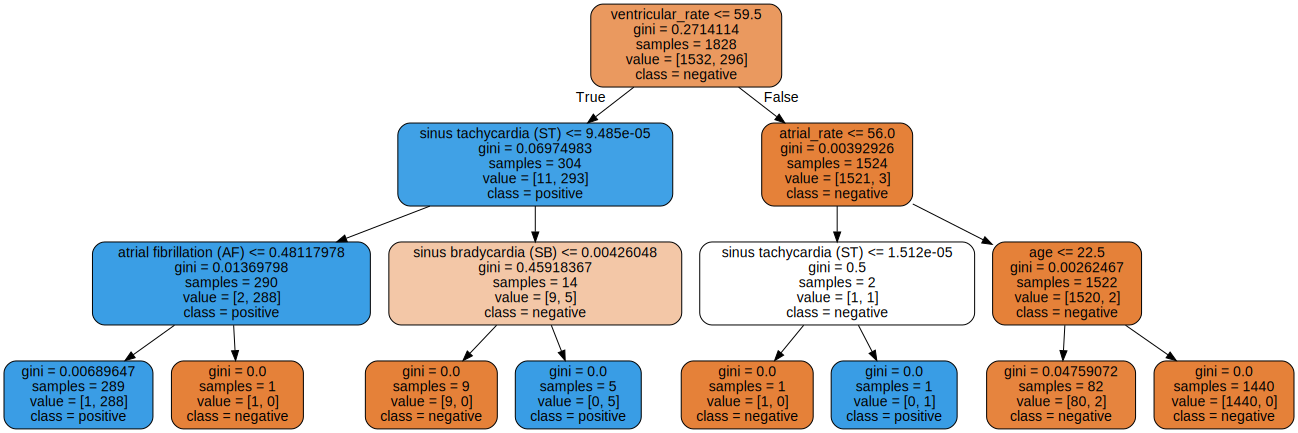

In [183]:
dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=DIAGS+['gender', 'age', 'ventricular_rate', 'atrial_rate', 'qt_intv'], class_names=['negative', 'positive'], filled=True, rounded=True, precision=8)
graph = graphviz.Source(dot_data, format='png') 
graph.render("dtree_with_std_feat")
graph

In [134]:
f1_score(y_test, dtree.predict(X_test))

0.98989898989899

In [146]:
def evaluate_dtree(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    # print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
    trees = []
    for i, label in enumerate(DIAGS):
        dtree = DecisionTreeClassifier(max_depth=3)
        dtree.fit(X_train, Y_train[:, i])
        y_test = Y_test[:, i]
        y_pred = dtree.predict(X_test)
        # print(dtree.score(X_test, Y_test[:, i]))
        print(label, '\t', f1_score(y_test, y_pred), '\t', recall_score(y_test, y_pred), '\t', precision_score(y_test, y_pred))
        trees.append(dtree)
    return trees

In [147]:
dtree_list = evaluate_dtree(Y_ecg, Y_ground)

1st degree AV block (1dAVb) 	 0.9066666666666667 	 0.9714285714285714 	 0.85
right bundle branch block (RBBB) 	 0.9047619047619048 	 0.8636363636363636 	 0.95
left bundle branch block (LBBB) 	 0.8955223880597014 	 0.8823529411764706 	 0.9090909090909091
sinus bradycardia (SB) 	 0.8695652173913043 	 0.8860759493670886 	 0.8536585365853658
atrial fibrillation (AF) 	 0.5 	 0.3333333333333333 	 1.0
sinus tachycardia (ST) 	 0.888888888888889 	 1.0 	 0.8


## Split  & Train

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score

In [139]:
def f1(model, X, y):
    return f1_score(model.predict(X), y)

In [170]:
for i in range(6):
    print(DIAGS[i], '\t', np.average(
    cross_val_score(DecisionTreeClassifier(max_depth=3), Y_ecg, Y_ground[:, i], scoring=f1)
    ))

1st degree AV block (1dAVb) 	 0.8410439728436426
right bundle branch block (RBBB) 	 0.861769534813013
left bundle branch block (LBBB) 	 0.880796044251975
sinus bradycardia (SB) 	 0.8186275407226752
atrial fibrillation (AF) 	 0.7354214413037943
sinus tachycardia (ST) 	 0.8989100201484103


In [ ]:
f1_score(Y_ecg[:, 3] > 0.00001, Y_ground[:, 3])

In [ ]:
1st degree AV block (1dAVb) 	 0.8302617943440728
right bundle branch block (RBBB) 	 0.8520829991665486
left bundle branch block (LBBB) 	 0.896147010883853
sinus bradycardia (SB) 	 0.984748032096953
atrial fibrillation (AF) 	 0.7673561732385261
sinus tachycardia (ST) 	 0.9215070532717592